# Load Models and Data

In [3]:
%load_ext autoreload
%autoreload 2

import torch
from torch_geometric.loader import DataLoader
from data_utils import *
from tqdm import tqdm
import pandas as pd

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from data_utils import *
from graph_vae.vae import GraphVAE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# old: ./checkpoints/graph_vae_20240416_221922.pt
model = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240502_125508.pt").to(device)
model.eval()
# old: ./checkpoints/graph_vae_20240416_225315.pt
model_split = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240503_021631.pt").to(device)
model_split.eval()

include_hydrogen = False

prop_norm_df = create_or_load_property_norm_df()
    
# create dataset and dataloaders
dataset = create_qm9_dataset(
    device=device, 
    include_hydrogen=False,
    refresh_data_cache=False,
    properties=model.properties,
    prop_norm_df=prop_norm_df
)

batch_size = 256
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# load training data smiles with properties to get the true properties of generated molecules
full_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
dataset_smiles_with_prop = dict()
for batch in tqdm(full_loader, desc="Converting dataset graphs to SMILES"):
    for sample_index in range(len(batch)):
        sample = batch[sample_index]
        mol = graph_to_mol(data=sample, includes_h=include_hydrogen, validate=False)
        dataset_smiles_with_prop[Chem.MolToSmiles(mol)] = model.denormalize_properties(sample.y)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



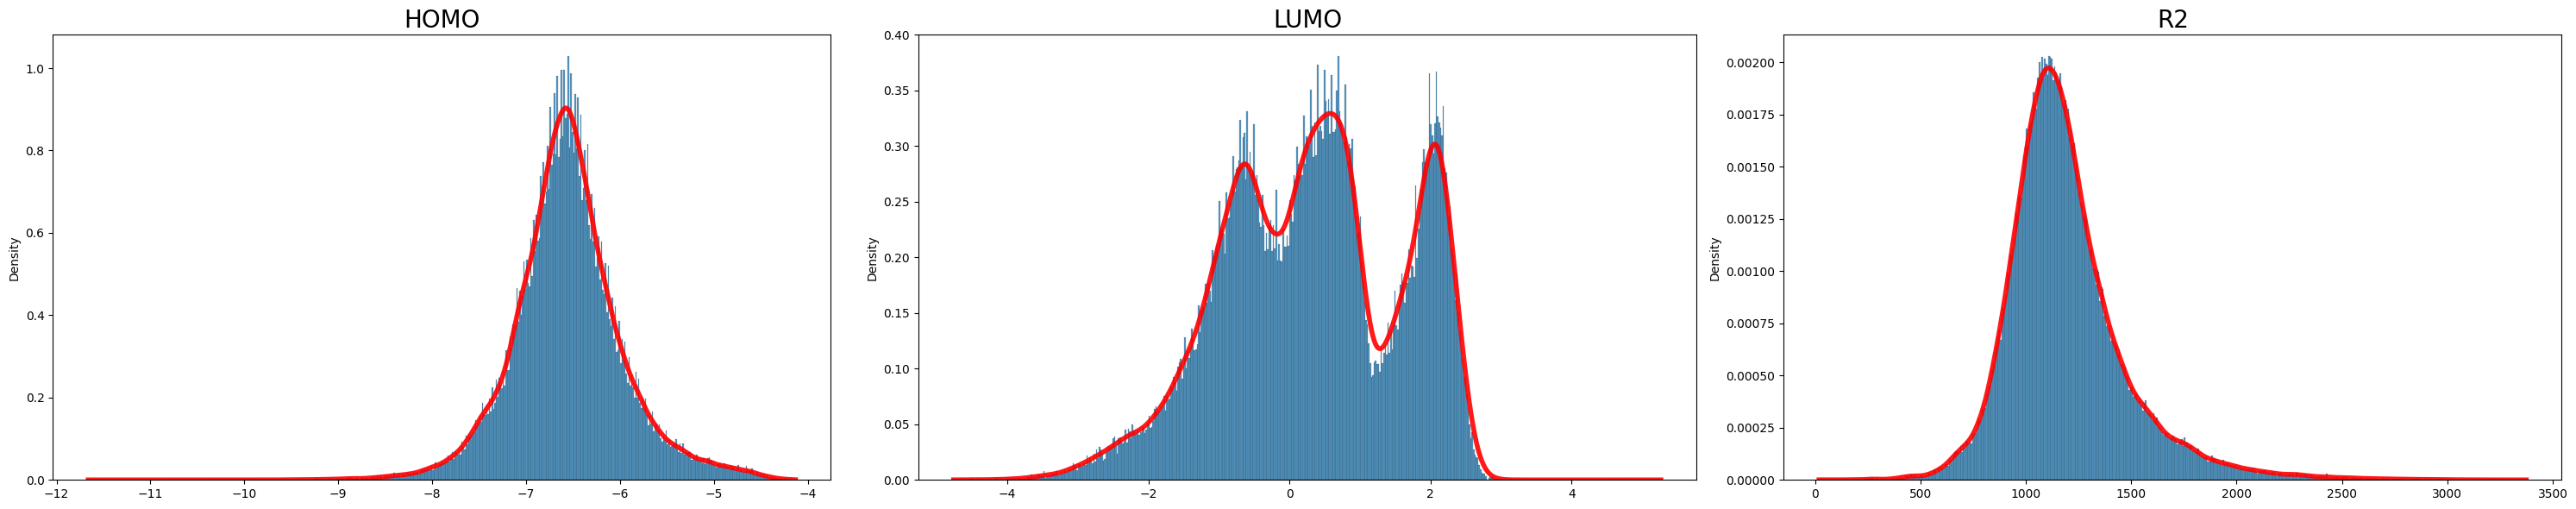

In [42]:
from scipy.stats import gaussian_kde

y_list = [y for y in dataset_smiles_with_prop.values()]
y = torch.cat(y_list, dim=0)
num_properties = len(model.properties)

fig, axes = plt.subplots(nrows=1, ncols=num_properties, figsize=(10 * num_properties, 6))
if num_properties == 1:
    axes = [axes]

x_d_list = []
density_dataset_list = []
for i, property in enumerate(model.properties):
    data = y[:, i].cpu().numpy()
    kde = gaussian_kde(data)
    x_d = np.linspace(np.min(data), np.max(data), 1000)
    x_d_list.append(x_d)
    density = kde(x_d)
    density_dataset_list.append(density)
    
    sns.histplot(data, bins=512, kde=False, stat='density', ax=axes[i])
    axes[i].plot(x_d, density, color='red', linewidth=4, alpha=0.9)
    axes[i].set_title(property.upper(), fontsize=20)

plt.tight_layout()
plt.show()

In [64]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS


#y_target = torch.tensor(data=[-8.1, -1.98, 1628.67], device=device).unsqueeze(0)
y_target = torch.tensor(data=[-5, -3, 800], device=device).unsqueeze(0)
y_target_norm = model.normalize_properties(y=y_target)


def pyro_model(y_obs):
    z = pyro.sample("z", dist.Normal(torch.zeros(model.property_z_size, device=device), torch.ones(model.property_z_size, device=device))).unsqueeze(0)

    y_mu, y_sigma = model.predict_properties(z)

    with pyro.plate("data"):
        pyro.sample("obs", dist.Normal(y_mu, y_sigma), obs=y_obs)


# Define the MCMC kernel, here using NUTS, which is good for continuous parameters
nuts_kernel = NUTS(pyro_model)

sample_count = 1500

# Run the MCMC sampler
mcmc = MCMC(nuts_kernel, num_samples=sample_count, warmup_steps=500)
mcmc.run(y_obs=y_target_norm)  # replace with your actual observed data

# Get the posterior samples
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 2000/2000 [06:51,  4.85it/s, step size=1.33e-01, acc. prob=0.798]


In [65]:
# decode posterior samples
x = model.decode(z=posterior_samples["z"])
dataset_mol_count = 0
y_sample_list = []
valid_count = 0
for i in tqdm(range(sample_count)):
    sample_matrices = (x[0][i:i+1], x[1][i:i+1], x[2][i:i+1])

    for _ in range(32):
        sample_graph = model.output_to_graph(x=sample_matrices, stochastic=True)

        # Check if the generated graph is connected
        if not nx.is_connected(pyg_utils.to_networkx(sample_graph, to_undirected=True)):
            continue

        try:
            mol = graph_to_mol(data=sample_graph, includes_h=include_hydrogen, validate=True)
        except Exception as e:
            # Molecule is invalid; try to decode again
            continue

        # Molecule is valid
        if mol:
            smiles = Chem.MolToSmiles(mol)
            if smiles in dataset_smiles_with_prop:
                y_sample_list.append(dataset_smiles_with_prop[smiles])
                dataset_mol_count += 1
                
print(dataset_mol_count)

100%|██████████| 1500/1500 [01:54<00:00, 13.08it/s]

9385


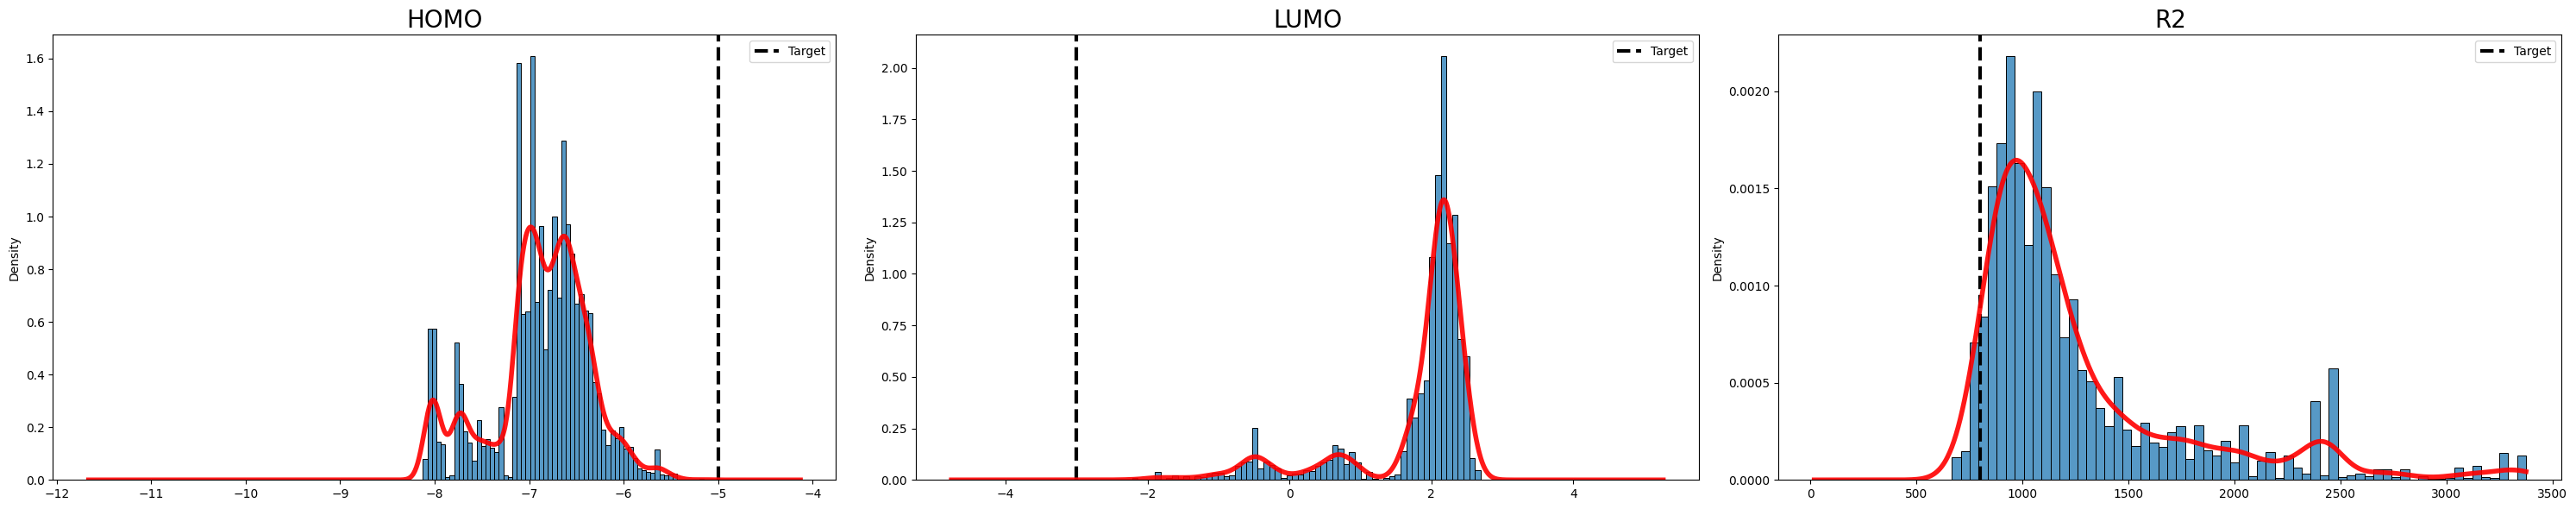

In [66]:
y_samples = torch.cat(y_sample_list, dim=0)
num_properties = len(model.properties)

fig, axes = plt.subplots(nrows=1, ncols=num_properties, figsize=(10 * num_properties, 6))
if num_properties == 1:
    axes = [axes]

density_sampled_list = []
for i, property in enumerate(model.properties):
    data = y_samples[:, i].cpu().numpy()
    kde = gaussian_kde(data)
    x_d = x_d_list[i]
    density = kde(x_d)
    density_sampled_list.append(density)
    
    sns.histplot(data, bins=64, kde=False, stat='density', ax=axes[i])
    axes[i].axvline(y_target[:, i].cpu().numpy(), color='k', linestyle='dashed', linewidth=3, label="Target")
    axes[i].plot(x_d, density, color='red', linewidth=4, alpha=0.9)
    axes[i].set_title(property.upper(), fontsize=20)
    axes[i].legend()

plt.tight_layout()
plt.show()

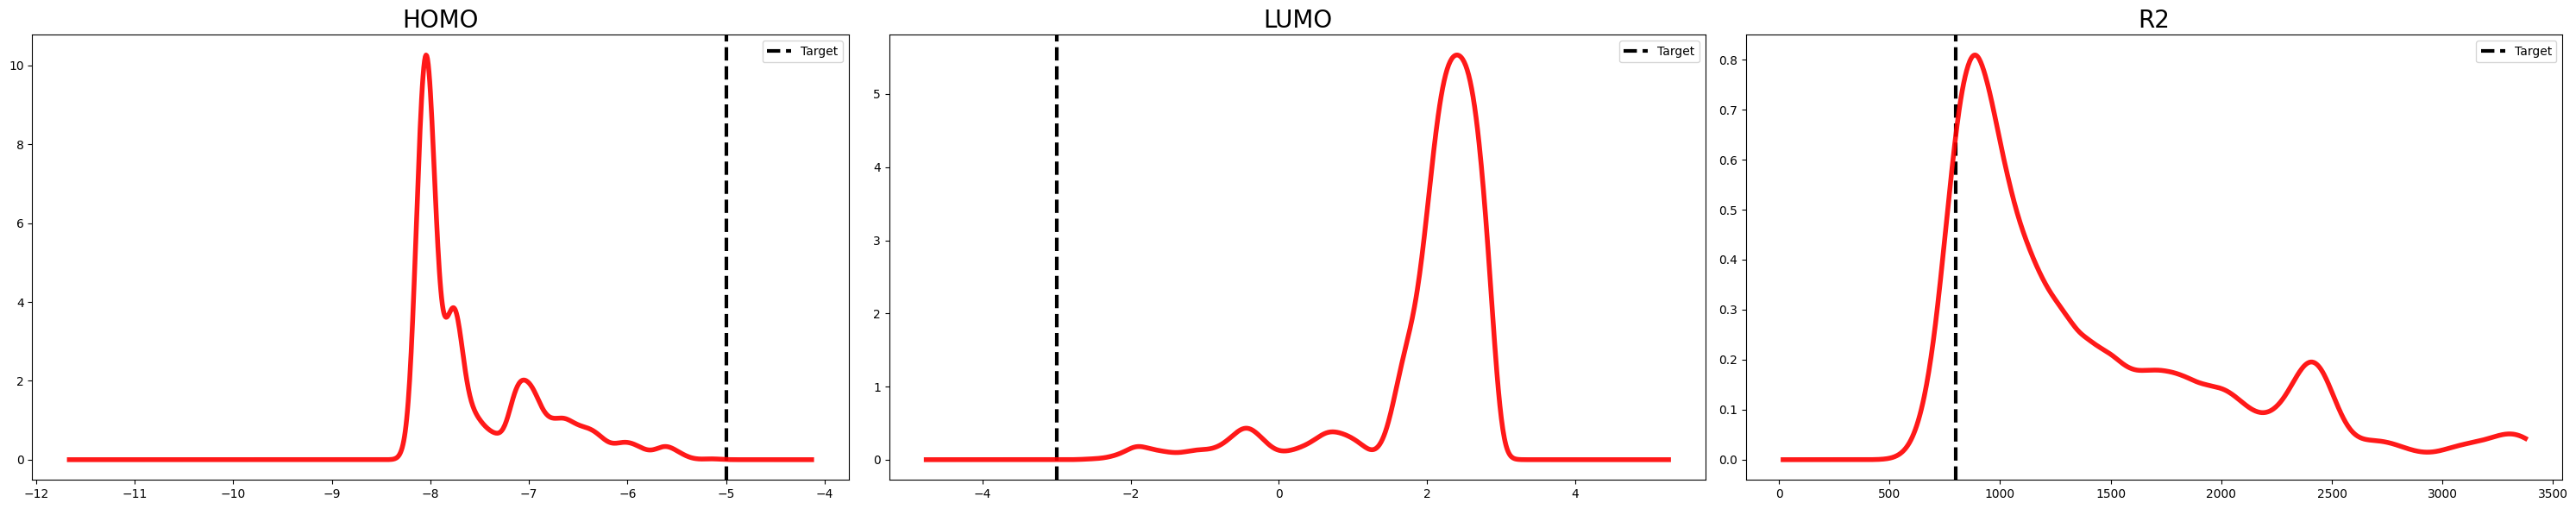

In [67]:
# plot relative density
num_properties = len(model.properties)
fig, axes = plt.subplots(nrows=1, ncols=num_properties, figsize=(10 * num_properties, 6))
if num_properties == 1:
    axes = [axes]

for i, property in enumerate(model.properties):

    x_d = x_d_list[i]
    density_dataset = density_dataset_list[i]
    density_sampled = density_sampled_list[i]
    density = density_sampled / (density_dataset + 0.001)
    
    axes[i].axvline(y_target[:, i].cpu().numpy(), color='k', linestyle='dashed', linewidth=3, label="Target")
    axes[i].plot(x_d, density, color='red', linewidth=4, alpha=0.9)
    axes[i].set_title(property.upper(), fontsize=20)
    axes[i].legend()

plt.tight_layout()
plt.show()